In [1]:
import gym
import numpy as np
import random
from collections import defaultdict
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt

<H1>Часть первая, с блекджеком и стратегиями</H1>

In [136]:
env = gym.make('Blackjack-v0')
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [3]:
env.action_space

Discrete(2)

In [4]:
n_episodes = 200000
rewards_sum = 0.

for edisode in range(n_episodes):
    state = env.reset()
    while True:
        if state[0] >= 19:
            state, reward, done, info = env.step(0)
        else:
            state, reward, done, info = env.step(1)
        if done:
            rewards_sum += reward
            break
            
print(rewards_sum / n_episodes)

-0.20023


In [4]:
def estimate_reward(policy, env, n_episodes=200000):
    rewards_sum = 0.

    for episode in range(n_episodes):
        trace = []
        state = env.reset()
        while True:
            action = policy(state)

            state, reward, done, info = env.step(action)

            if done:
                rewards_sum += reward
                break

    return rewards_sum / n_episodes


class policy_from_Q:
    def __init__(self, Q):
        self.Q = Q
    def __call__(self, state):
        if state not in self.Q:
            return random.randrange(env.action_space.n)
        else:
            return np.argmax(self.Q[state])

In [9]:
def q_learn(env, n_episodes=500000):
    Q = defaultdict(lambda: [0.] * env.action_space.n)

    eps = .05
    gamma = 1.
    alpha = .01

    for episode in range(n_episodes):
        state = env.reset()
        while True:
            if random.random() < eps:
                action = random.randrange(env.action_space.n)
            else:
                action = np.argmax(Q[state])

            new_state, reward, done, info = env.step(action)
            
            if done:
                Q[state][action] += alpha * (reward - Q[state][action])
            else:
                Q[state][action] += alpha * (reward + gamma * max(Q[new_state]) - Q[state][action])
            state = new_state
            
            if done:
                break
    
    return Q

In [139]:
Q = q_learn(env)
print(estimate_reward(policy_from_Q(Q), env))

-0.052125


In [20]:
def on_policy_mc(env, n_episodes=500000):
    ret_sum = defaultdict(lambda: [0.] * env.action_space.n)
    ret_n = defaultdict(lambda: [0] * env.action_space.n)
    Q = defaultdict(lambda: [0.] * env.action_space.n)

    eps = 0.2
    gamma = 1.

    state = env.reset()
    for episode in range(n_episodes):
        trace = []
        state = env.reset()
        while True:
            if random.random() < eps:
                action = random.randrange(env.action_space.n)
            else:
                action = np.argmax(Q[state])

            trace.append([state, action])
            state, reward, done, info = env.step(action)

            if done:
                break

        G = reward
        for (st, action) in trace[::-1]:        
            ret_sum[st][action] += G
            ret_n[st][action] += 1
            Q[st][action] = ret_sum[st][action] / ret_n[st][action]
            G *= gamma
    
    return Q

In [7]:
Q = on_policy_mc(env)
print(estimate_reward(policy_from_Q(Q), env))

-0.05369


In [7]:
def off_policy_mc(env, n_episodes=400001, eps=0.2, gamma=1., estimate_step=0):
    Q = defaultdict(lambda: [0.] * env.action_space.n)
    C = defaultdict(lambda: [0.] * env.action_space.n)
    rewards_history = []
    
    for episode in range(n_episodes):
        if estimate_step and episode % estimate_step == 0:
            rewards_history.append(estimate_reward(policy_from_Q(Q), env))
        
        trace = []
        state = env.reset()
        while True:
            if random.random() < eps:
                action = random.randrange(env.action_space.n)
            else:
                action = np.argmax(Q[state])

            trace.append([state, action])
            state, reward, done, info = env.step(action)

            if done:
                break

        G = reward
        W = 1.
        for (st, action) in trace[::-1]:
            C[st][action] += W
            Q[st][action] += W / C[st][action] * (G - Q[st][action])

            if action != np.argmax(Q[st]):
                break

            W /= (1. - eps/env.action_space.n) 
            G *= gamma
    
    return Q, rewards_history

In [31]:
Q, rewards_history = off_policy_mc(env, estimate_step=20000)
print(estimate_reward(policy_from_Q(Q), env))

-0.04764


off_policy_mc дает лучшие результаты, будем строить графики для этого метода

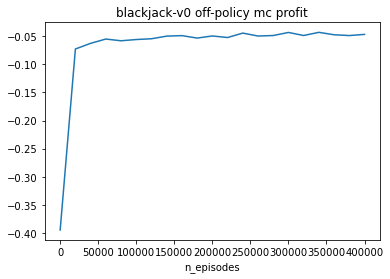

In [37]:
plt.title('blackjack-v0 off-policy mc profit')
plt.xlabel('n_episodes')
plt.plot(range(0, 400001, 20000), rewards_history)

<H1>Часть вторая, удвоенная</H1>

In [36]:
from gym.envs.toy_text.blackjack import draw_hand, sum_hand, usable_ace, is_bust, cmp, draw_card, \
    score

class BlackjackDoubleEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
                if self.natural and is_natural(self.player) and reward == 2.:
                    reward = 3.
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [126]:
env = BlackjackDoubleEnv()
Q, rewards_history = off_policy_mc(env, estimate_step=20000)
print(estimate_reward(policy_from_Q(Q), env))

-0.03855


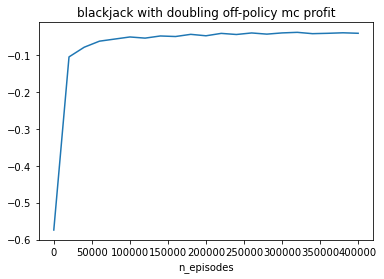

In [128]:
plt.title('blackjack with doubling off-policy mc profit')
plt.xlabel('n_episodes')
plt.plot(range(0, 400001, 20000), rewards_history)

<H1>Часть третья, в главной роли — Дастин Хоффман</H1>
Добавлен подсчет карт по системе "Половинки". Поскольку проброс вознаграждения на действия в предыдущих играх не очень полезен в конце каждой игры возвращается done, однако reset() не перемешивает карты без необходимости.

In [12]:
cards_count = [-1, 0.5, 1, 1, 1.5, 1, .5, 0, -0.5, -1]

class BlackjackCountEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.full_reset()

    def _draw_card(self):
        result = self.deck[self.position]
        self.position += 1
        self.drawn_cards_sum += cards_count[result-1]
        return result
    
    def _draw_hand(self):
        return [self._draw_card(), self._draw_card()]    
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            self.player.append(self._draw_card())
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self._draw_card())
                reward = cmp(score(self.player), score(self.dealer)) * 2
                if self.natural and is_natural(self.player) and reward == 2.:
                    reward = 3.
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(self._draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self._draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        if done:
            if (len(self.deck) - self.position < 15):
                self._shuffle_deck()
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], self.drawn_cards_sum,
                usable_ace(self.player))

    def _shuffle_deck(self):
        random.shuffle(self.deck)
        self.position = 0
        self.drawn_cards_sum = 0.
    
    def full_reset(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self._shuffle_deck() 
        self.reset()
    
    def reset(self):
       # self._shuffle_deck() 
       # self.dealer = self._draw_hand()
        self.dealer = [self._draw_card()]
        self.player = self._draw_hand()
        return self._get_obs()

In [13]:
env = BlackjackCountEnv()
Q, rewards_history = off_policy_mc(env, n_episodes=10000000, estimate_step=500000)
estimate_reward(policy_from_Q(Q), env, n_episodes=400000)

-0.0296925

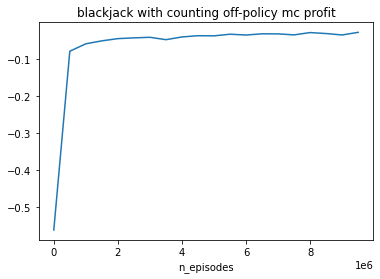

In [125]:
plt.title('blackjack with counting off-policy mc profit')
plt.xlabel('n_episodes')
plt.plot(range(0, 10000000, 500000), rewards_history)

<H1>Часть четвёртая, опциональная</H1>
Решение уравнений Беллмана для V

In [129]:
transitions = {}

def calc_transition(state):
    if (state) in transitions:
        return
    
    hand_sum, usable_ace = state

    state_transitions = []
    transitions[state] = state_transitions
    bust_proba = 0.
    
    def append_transition(proba, hand_sum, card, usable_ace):
        nonlocal bust_proba
        if card == 1 and not usable_ace and hand_sum + 11 <= 21:
            hand_sum += 11
            usable_ace = True
        else:
            hand_sum += card
            
        if usable_ace and hand_sum > 21:
            hand_sum -= 10
            usable_ace = False
        
        if hand_sum > 21:
            bust_proba += proba
        else:
            state_transitions.append((proba, (hand_sum, usable_ace)))
            calc_transition((hand_sum, usable_ace))
    
    for card in range(1, 10):
        append_transition(1/13, hand_sum, card, usable_ace)
            
    append_transition(4/13, hand_sum, 10, usable_ace)

    if bust_proba > 0:
        state_transitions.append((bust_proba, (-1, False)))
                    
for card_sum in range(4, 20):
    calc_transition((card_sum, False))
for card_sum in range(12, 21):
    calc_transition((card_sum, True))

In [130]:
def calc_dealer_sum(first_card):
    dealer_sum_probas = {-1: 0., 17: 0., 18.: 0, 19: 0., 20: 0., 21: 0.}
    state_probas = defaultdict(float)
    state_probas[first_card, first_card == 1] = 1.
    
    def add_proba(proba, hand_sum, has_ace):
        card_sum = hand_sum
        if has_ace and hand_sum + 10 <= 21:
            card_sum += 10
        if card_sum > 21:
            dealer_sum_probas[-1] += proba
        elif card_sum >= 17:
            dealer_sum_probas[card_sum] += proba
        else: 
            state_probas[hand_sum, has_ace] += proba
        
    while (state_probas):
        hand_sum, has_ace = min(state_probas)
        state_proba = state_probas[hand_sum, has_ace]
        add_proba(state_proba*1/13, hand_sum+1, True)
        for card in range(2, 10):
            add_proba(state_proba*1/13, hand_sum+card, has_ace)
        add_proba(state_proba*4/13, hand_sum+10, has_ace)
        
        del state_probas[hand_sum, has_ace]
    return dealer_sum_probas
    
dealer_sum_probas = {card: calc_dealer_sum(card) for card in range(1, 11)}

In [131]:
V = {}

for state_hand in transitions.keys():
    for state_dealer in dealer_sum_probas.keys():
        V[state_hand, state_dealer] = random.random()

In [132]:
def calc_q(state_hand, state_dealer, gamma=1.):
    state_transitions = transitions[state_hand]
    state_dealear_sum_probas = dealer_sum_probas[state_dealer]
    
    q_hit = 0.
    for proba, next_state in state_transitions:
        if next_state == (-1, False):
            q_hit += proba * -1
        else:
            q_hit += proba * gamma * V[next_state, state_dealer]
            
    q_stick = 0.
    card_sum, usable_ace = state_hand
    for dealear_sum, proba in state_dealear_sum_probas.items():
        if dealear_sum < card_sum:
            q_stick += proba
        elif dealear_sum > card_sum:
            q_stick -= proba
    
    return q_stick, q_hit

for n_iter in range(10):
    for state_hand in transitions.keys():
        for state_dealer in dealer_sum_probas.keys():
            V[state_hand, state_dealer] = max(calc_q(state_hand, state_dealer))

In [133]:
class policy_from_V:
    def __init__(self, V):
        self.V = V
    def __call__(self, state):
        hand_sum, dealer_card, usable_ace = state
        return np.argmax(calc_q((hand_sum, usable_ace), dealer_card))

In [135]:
env = gym.make('Blackjack-v0')

estimate_reward(policy_from_V(V), env)

-0.04541